In [1]:
from collect_data import *
from collect_metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device(
    "cuda:{}".format(1) if torch.cuda.is_available() else "cpu"
)
print(device)

cuda:1


In [3]:
stimuli_path = meg_path + '/stimuli/audio'
wav_files_duration = {}

for filename in os.listdir(stimuli_path):
    if filename.endswith('.wav'): 
        file_path = os.path.join(stimuli_path, filename)
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        wav_files_duration[filename.rstrip('.wav')] = duration
print('WAVE FILES DURATION: ',wav_files_duration)
print('WAVE FILES WITH\ NUMBERS: ',task)
wav_list_without_numb = list(task.keys())


megsp_path = os.path.join(meg_path, 'collect_data/megsp')
megsp_list = os.listdir(megsp_path)

select_subj = "01"
megsp_list_session_0 = [f for f in megsp_list if f.startswith(select_subj) and f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.startswith(select_subj) and f.split('_')[1] == '1']

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)

WAVE FILES DURATION:  {'lw1': 318.1481632653061, 'lw1_3': 53.072426303854876, 'lw1_2': 93.7512925170068, 'lw1_1': 75.44276643990929, 'lw1_0': 95.88167800453515, 'easy_money_7': 129.30312925170068, 'easy_money_6': 123.42730158730159, 'easy_money_4': 163.68920634920636, 'easy_money_5': 142.36866213151927, 'easy_money_3': 141.97519274376418, 'easy_money_0': 143.12875283446712, 'easy_money_2': 180.43360544217688, 'easy_money_1': 104.10834467120182, 'cable_spool_fort_4': 123.26390022675737, 'cable_spool_fort_5': 54.69605442176871, 'cable_spool_fort_3': 105.82820861678005, 'cable_spool_fort_2': 137.65614512471655, 'cable_spool_fort_1': 134.8726984126984, 'cable_spool_fort_0': 100.59777777777778, 'the_black_willow_9': 188.23668934240362, 'the_black_willow_8': 142.4142403628118, 'the_black_willow_7': 172.399410430839, 'the_black_willow_6': 128.21628117913832, 'the_black_willow_5': 81.94331065759637, 'the_black_willow_4': 110.45659863945578, 'the_black_willow_2': 125.23859410430839, 'the_black_

## Build 8 subjects prediction

In [4]:
real_target = []
for channel in range(num_channel):
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)
    real_target.append(y_test)


In [5]:
extr_path = meg_path + "/collect_data"
subjects_metrics = {}
real_target = torch.tensor(np.array(real_target))
real_target = real_target.reshape(real_target.shape[0], real_target.shape[1], 16, 26)

for repo in tqdm(os.listdir(extr_path)[3:-2]):
    subject = repo[-2:]
    subj_path = extr_path + '/' + repo + '/'
    pred_meg_y = torch.load(os.path.join(subj_path, 'meg_prediction_ridge_'+subject+'.pt')) 
    pred_meg_y = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], 16, 26)
    subjects_metrics['subject_'+subject] = bands_metrics(real_target, pred_meg_y, freq_bands)


    

100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


In [6]:
[entry['pearson_corr'] for entry in subjects_metrics['subject_01']['delta']]

[0.33743487649712345,
 0.3057680789786257,
 0.32982971841346587,
 0.34458603855843717,
 0.2390772725478157,
 0.30180847332786687,
 0.38775061090657137,
 0.3555426250961689,
 0.4482580546217333,
 0.3507956631694702,
 0.3263265775769728,
 0.32919714485278734,
 0.25912566582914465,
 0.38286593759983467,
 0.364030487704511,
 0.30351802432727676,
 0.19576968309523624,
 0.35393282943709053,
 0.3341153419140896,
 0.28928345750712425,
 0.23429773579854177,
 0.473959314407609,
 0.30249922783324507,
 0.33449512625713906,
 0.4261957538114477,
 0.3430816824836759,
 0.35271442709553097,
 0.2979697797777561,
 0.3914344976914306,
 0.39629941753615866,
 0.37568726372449124,
 0.35209196641502855,
 0.2014574522465908,
 0.3123259774285428,
 0.34719226837328415,
 0.34684343793491046,
 0.2758323915826283,
 0.373863342298661,
 0.3861461113687004,
 0.39875068566927857,
 0.32940611149295357,
 0.40281071283035613,
 0.36545597970390464,
 0.3535180652449026,
 0.3358196396919718,
 0.37545187631555577,
 0.32142711

In [7]:
data_frame = []
for subject, metrics in subjects_metrics.items():
    for band, channels in metrics.items():
        for channel_data in channels:
            row = {'Subject': subject, 'Band': band, 'Channel': channel_data['channel']}
            row.update(channel_data)
            del row['channel']  
            data_frame.append(row)

df = pd.DataFrame(data_frame)

In [8]:
df

,Subject,Band,Channel,pearson_corr,modified_r2,mse,mae,mae_norm
0,subject_01,delta,0,0.337435,0.113862,72.334193,6.330189,0.562355
1,subject_01,delta,1,0.305768,0.093494,70.490160,6.406631,0.523824
2,subject_01,delta,2,0.329830,0.108788,70.297294,6.246990,0.547915
3,subject_01,delta,3,0.344586,0.118740,72.663585,6.234757,0.525704
4,subject_01,delta,4,0.239077,0.057158,80.826299,6.658844,0.559821
...,...,...,...,...,...,...,...,...
6651,subject_09,beta,203,0.435552,0.189706,74.364649,6.421975,0.259937
6652,subject_09,beta,204,0.276860,0.076651,58.514737,5.938117,0.254586
6653,subject_09,beta,205,0.155137,0.024068,65.381527,6.249613,0.285588
6654,subject_09,beta,206,0.186788,0.034890,58.731724,5.917459,0.266956


Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:49: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


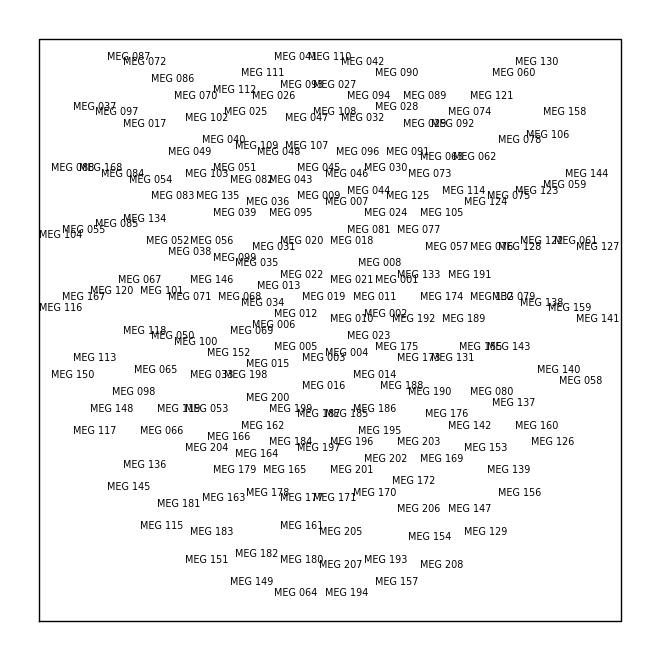

Figure(640x640)


In [9]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())

## Ceiling

In [29]:
import itertools

subjects_list = ['01', '02', '04', '05', '06', '07', '08', '09']
combinations = itertools.combinations(subjects_list, 2)

In [30]:
combination_list = []

for combo in tqdm(combinations):
    subj_i = combo[0]
    subj_j = combo[1]

    megsp_list_session_0_i = [f for f in megsp_list if f.startswith(subj_i) and f.split('_')[1] == '0']
    megsp_list_session_1_i = [f for f in megsp_list if f.startswith(subj_i) and f.split('_')[1] == '1']
    meg_0_tensor_train_i, _, _ = get_splitted_tensor(megsp_list_session_0_i, megsp_path)
    meg_1_tensor_train_i, _, _ = get_splitted_tensor(megsp_list_session_1_i, megsp_path)
    meg_tensor_train_i = torch.cat((meg_0_tensor_train_i, meg_1_tensor_train_i), 0)
    
    megsp_list_session_0_j = [f for f in megsp_list if f.startswith(subj_j) and f.split('_')[1] == '0']
    megsp_list_session_1_j = [f for f in megsp_list if f.startswith(subj_j) and f.split('_')[1] == '1']
    meg_0_tensor_train_j, _, _ = get_splitted_tensor(megsp_list_session_0_j, megsp_path)
    meg_1_tensor_train_j, _, _ = get_splitted_tensor(megsp_list_session_1_j, megsp_path)
    meg_tensor_train_j = torch.cat((meg_0_tensor_train_j, meg_1_tensor_train_j), 0)

    r2_channels = []
    for i in tqdm(range(num_channel)):
        pearson_corr = np.corrcoef(meg_tensor_train_i[:,i,:].reshape(-1), meg_tensor_train_j[:,i,:].reshape(-1))[0,1]
        modified_r2 = np.abs(pearson_corr) * pearson_corr
        r2_channels.append(modified_r2)

    combination_list.append(r2_channels)


28it [12:21, 26.47s/it]


In [42]:
for i in range(len(combination_list)):
    combination_list[i] = torch.Tensor(combination_list[i])
comb_torch = torch.stack(combination_list)

In [44]:
mean_vector = torch.mean(comb_torch, dim=0)

In [45]:
# CEILING VALUES OF R2

mean_vector

tensor([0.0427, 0.0378, 0.0272, 0.0347, 0.0300, 0.0393, 0.0429, 0.0400, 0.0459,
        0.0284, 0.0320, 0.0275, 0.0334, 0.0487, 0.0416, 0.0341, 0.0662, 0.0392,
        0.0239, 0.0394, 0.0307, 0.0291, 0.0394, 0.0482, 0.0840, 0.0730, 0.0582,
        0.0666, 0.0755, 0.0535, 0.0420, 0.0540, 0.0609, 0.0427, 0.0424, 0.0585,
        0.0976, 0.0643, 0.0633, 0.0859, 0.0673, 0.0703, 0.0537, 0.0465, 0.0488,
        0.0432, 0.0582, 0.0608, 0.0717, 0.0704, 0.0735, 0.0747, 0.0669, 0.0782,
        0.0961, 0.0526, 0.0548, 0.0946, 0.0821, 0.0693, 0.0888, 0.0838, 0.0752,
        0.0708, 0.0726, 0.0810, 0.0817, 0.0455, 0.0458, 0.0760, 0.0638, 0.0764,
        0.0666, 0.0794, 0.0759, 0.0655, 0.0643, 0.0708, 0.0437, 0.0603, 0.0506,
        0.0628, 0.0791, 0.0954, 0.0915, 0.0728, 0.0741, 0.0998, 0.0807, 0.0729,
        0.0646, 0.0864, 0.0663, 0.0621, 0.0451, 0.0527, 0.0820, 0.0697, 0.0492,
        0.0632, 0.0739, 0.0872, 0.0785, 0.1099, 0.0621, 0.0787, 0.0601, 0.0544,
        0.0679, 0.0654, 0.0775, 0.0921, 